## 1.Data Preparation

The purpose of this work is to train a multi-label classifier via Bert to predict OCEAN personality traits.

Chi Zhang | August 2022

### Environment setup

In [ ]:
!pip install -q transformers==2.3.0

     |████████████████████████████████| 447 kB 35.0 MB/s 
     |████████████████████████████████| 132 kB 73.3 MB/s 
     |████████████████████████████████| 1.3 MB 56.2 MB/s 
     |████████████████████████████████| 880 kB 70.9 MB/s 
     |████████████████████████████████| 9.1 MB 51.6 MB/s 
     |████████████████████████████████| 79 kB 9.3 MB/s 
     |████████████████████████████████| 139 kB 70.8 MB/s 
     |████████████████████████████████| 127 kB 76.1 MB/s 


In [ ]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 
# good output must be => ['/device:CPU:0', '/device:GPU:0']

['/device:CPU:0', '/device:GPU:0']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_directory = './drive/MyDrive/datasets/stream_of_consciousness/'

In [ ]:
!mkdir data
!cp {dataset_directory}/essays.csv -d data/

mkdir: cannot create directory ‘data’: File exists


### Import

In [ ]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

In [ ]:
data_path = 'data/essays.csv'

In [ ]:
df_raw = pd.read_csv(data_path, encoding='cp1252')

df_raw.head()

,#AUTHID,TEXT,cEXT,cNEU,cAGR,cCON,cOPN
0,1997_504851.txt,"Well, right now I just woke up from a mid-day ...",n,y,y,n,y
1,1997_605191.txt,"Well, here we go with the stream of consciousn...",n,n,y,n,n
2,1997_687252.txt,An open keyboard and buttons to push. The thin...,n,y,n,y,y
3,1997_568848.txt,I can't believe it! It's really happening! M...,y,n,y,y,n
4,1997_688160.txt,"Well, here I go with the good old stream of co...",y,n,y,n,y


In [ ]:
# replace binary strings with 0 and 1
label_cols = ['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']

for col in label_cols:
  df_raw[col].replace({'n':0, "y":1}, inplace=True)

### EDA Session

In [ ]:
df_raw.shape

(2468, 7)

In [ ]:
lens = df_raw.TEXT.str.len()
lens.mean(), lens.std(), lens.max()

(3294.95056726094, 1288.7235795620943, 12852)

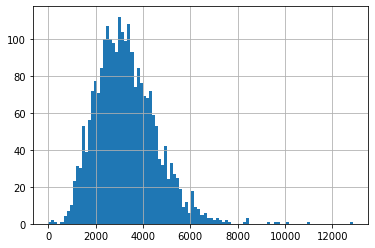

In [ ]:
# distribution of text lengths
lens.hist(bins=100)

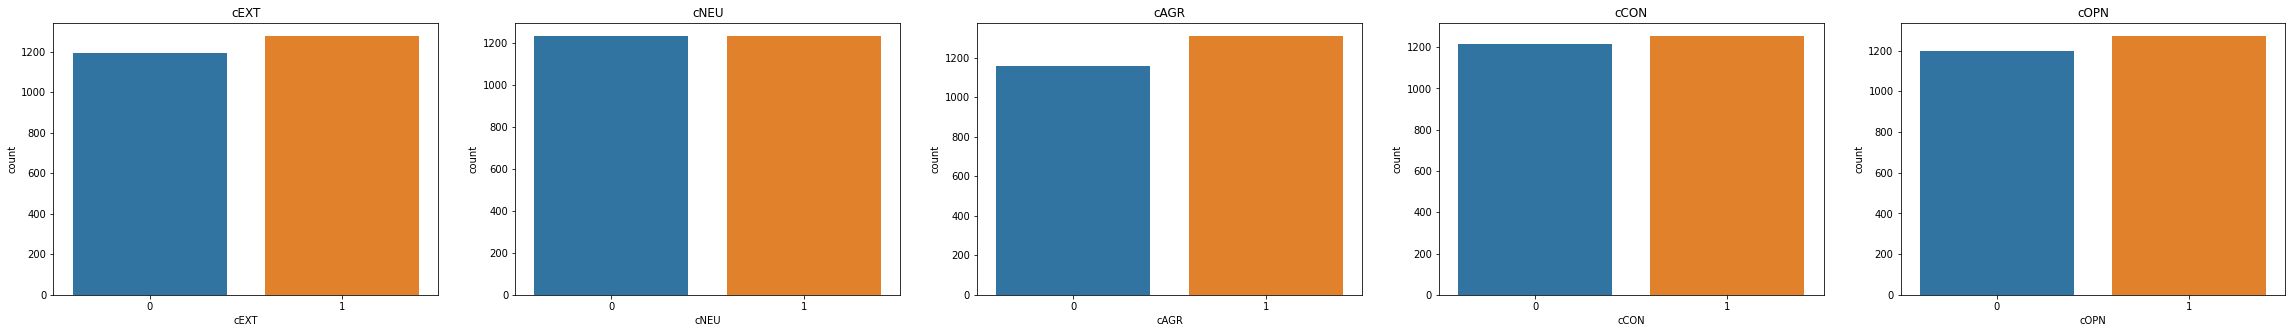

In [ ]:
f, axes = plt.subplots(1,5,figsize=(40,5), sharex=True)
for f,ax in zip(label_cols, axes.ravel()):
    sns.countplot(df_raw[f], ax=ax)
    ax.set_title(f)

### Extract Toxic column only

### Sampling

In [ ]:
df_cEXT = df_raw.iloc[:,1:3]
df_cEXT.head()

,TEXT,cEXT
0,"Well, right now I just woke up from a mid-day ...",0
1,"Well, here we go with the stream of consciousn...",0
2,An open keyboard and buttons to push. The thin...,0
3,I can't believe it! It's really happening! M...,1
4,"Well, here I go with the good old stream of co...",1


In [ ]:
from transformers import BertTokenizer
from keras.preprocessing.sequence import pad_sequences

bert_model_name = 'bert-base-uncased'

tokenizer = BertTokenizer.from_pretrained(bert_model_name, do_lower_case=True)
MAX_LEN = 2048

def tokenize_sentences(sentences, tokenizer, max_seq_len = 1024):
    tokenized_sentences = []

    for sentence in tqdm(sentences):
        tokenized_sentence = tokenizer.encode(
                            sentence,                  # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_seq_len,  # Truncate all sentences.
                    )
        
        tokenized_sentences.append(tokenized_sentence)

    return tokenized_sentences

def create_attention_masks(tokenized_and_padded_sentences):
    attention_masks = []

    for sentence in tokenized_and_padded_sentences:
        att_mask = [int(token_id > 0) for token_id in sentence]
        attention_masks.append(att_mask)

    return np.asarray(attention_masks)

input_ids = tokenize_sentences(df_cEXT['TEXT'], tokenizer, MAX_LEN)
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
attention_masks = create_attention_masks(input_ids)

  0%|          | 0/2468 [00:00<?, ?it/s]

In [ ]:
TEST_SIZE = 0.2
label_cols = ['cEXT']
labels =  df_cEXT[label_cols].values

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=42, test_size=TEST_SIZE)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=42, test_size=TEST_SIZE)

train_size = len(train_inputs)
validation_size = len(validation_inputs)

In [ ]:
BATCH_SIZE = 1
NR_EPOCHS = 20

def create_dataset(data_tuple, epochs=1, batch_size=32, buffer_size=10000, train=True):
    dataset = tf.data.Dataset.from_tensor_slices(data_tuple)
    if train:
        dataset = dataset.shuffle(buffer_size=buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size)
    if train:
        dataset = dataset.prefetch(1)
    
    return dataset

train_dataset = create_dataset((train_inputs, train_masks, train_labels), epochs=NR_EPOCHS, batch_size=BATCH_SIZE)
validation_dataset = create_dataset((validation_inputs, validation_masks, validation_labels), epochs=NR_EPOCHS, batch_size=BATCH_SIZE)

## 2. BERT Model
- Load the pretrained BERT base-model from Transformers library
- Take the first hidden-state from BERT output (corresponding to CLS token) and feed it into a Dense layer with 6 neurons and sigmoid activation (Classifier). The outputs of this layer can be interpreted as probabilities for each of the 6 classes.

In [ ]:
from transformers import TFBertModel
from tensorflow.keras.layers import Dense, Flatten

class BertClassifier(tf.keras.Model):    
    def __init__(self, bert: TFBertModel, num_classes: int):
        super().__init__()
        self.bert = bert
        self.classifier = Dense(num_classes, activation='sigmoid')
        
    @tf.function
    def call(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None):
        outputs = self.bert(input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids,
                            position_ids=position_ids,
                            head_mask=head_mask)
        cls_output = outputs[1]
        cls_output = self.classifier(cls_output)
                
        return cls_output

model = BertClassifier(TFBertModel.from_pretrained(bert_model_name), len(label_cols))

## 3. Training Loop
- Use BinaryCrossentropy as loss function (is calculated for each of the output 6 output neurons ...that's like training 6 binary classification tasks at the same time) 
- Use the AdamW optimizer with 1-cycle-policy from the Transformers library
- AUC evaluation metrics

In [ ]:
import time
from transformers import create_optimizer

steps_per_epoch = train_size // BATCH_SIZE
validation_steps = validation_size // BATCH_SIZE

# | Loss Function
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=False)
train_loss = tf.keras.metrics.Mean(name='train_loss')
validation_loss = tf.keras.metrics.Mean(name='test_loss')

# | Optimizer (with 1-cycle-policy)
warmup_steps = steps_per_epoch // 3
total_steps = steps_per_epoch * NR_EPOCHS - warmup_steps
optimizer = create_optimizer(init_lr=5e-6, num_train_steps=total_steps, num_warmup_steps=warmup_steps)

# | Metrics
train_auc_metrics = [tf.keras.metrics.AUC() for i in range(len(label_cols))]
validation_auc_metrics = [tf.keras.metrics.AUC() for i in range(len(label_cols))]

@tf.function
def train_step(model, token_ids, masks, labels):
    labels = tf.dtypes.cast(labels, tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(token_ids, attention_mask=masks)
        loss = loss_object(labels, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables), 1.0)

    train_loss(loss)

    for i, auc in enumerate(train_auc_metrics):
        auc.update_state(labels[:,i], predictions[:,i])
        
@tf.function
def validation_step(model, token_ids, masks, labels):
    labels = tf.dtypes.cast(labels, tf.float32)

    predictions = model(token_ids, attention_mask=masks, training=False)
    v_loss = loss_object(labels, predictions)

    validation_loss(v_loss)
    for i, auc in enumerate(validation_auc_metrics):
        auc.update_state(labels[:,i], predictions[:,i])
                                              
def train(model, train_dataset, val_dataset, train_steps_per_epoch, val_steps_per_epoch, epochs):
    for epoch in range(epochs):
        print('=' * 50, f"EPOCH {epoch}", '=' * 50)

        start = time.time()

        for i, (token_ids, masks, labels) in enumerate(tqdm(train_dataset, total=train_steps_per_epoch)):
            train_step(model, token_ids, masks, labels)
            if i % 100 == 0: #TODO: 1000
                print(f'\nTrain Step: {i}, Loss: {train_loss.result()}')
                for i, label_name in enumerate(label_cols):
                    print(f"{label_name} roc_auc {train_auc_metrics[i].result()}")
                    train_auc_metrics[i].reset_states()
        
        for i, (token_ids, masks, labels) in enumerate(tqdm(val_dataset, total=val_steps_per_epoch)):
            validation_step(model, token_ids, masks, labels)

        print(f'\nEpoch {epoch+1}, Validation Loss: {validation_loss.result()}, Time: {time.time()-start}\n')

        for i, label_name in enumerate(label_cols):
            print(f"{label_name} roc_auc {validation_auc_metrics[i].result()}")
            validation_auc_metrics[i].reset_states()

        print('\n')

        
train(model, train_dataset, validation_dataset, train_steps_per_epoch=steps_per_epoch, val_steps_per_epoch=validation_steps, epochs=NR_EPOCHS)

================================================== EPOCH 0 ==================================================


  0%|          | 0/1974 [00:00<?, ?it/s]


Train Step: 0, Loss: 0.8218463659286499
cEXT roc_auc 0.0

Train Step: 100, Loss: 0.70310378074646
cEXT roc_auc 0.4617846608161926

Train Step: 200, Loss: 0.7068359851837158
cEXT roc_auc 0.39000001549720764

Train Step: 300, Loss: 0.7059844136238098
cEXT roc_auc 0.46038419008255005

Train Step: 400, Loss: 0.7015494108200073
cEXT roc_auc 0.5429546236991882

Train Step: 500, Loss: 0.7185882925987244
cEXT roc_auc 0.4449779987335205

Train Step: 600, Loss: 0.7182090282440186
cEXT roc_auc 0.48133280873298645

Train Step: 700, Loss: 0.7214738726615906
cEXT roc_auc 0.42648234963417053

Train Step: 800, Loss: 0.7199851274490356
cEXT roc_auc 0.5552220940589905

Train Step: 900, Loss: 0.7238600850105286
cEXT roc_auc 0.46820002794265747

Train Step: 1000, Loss: 0.7208956480026245
cEXT roc_auc 0.602053165435791

Train Step: 1100, Loss: 0.7406911849975586
cEXT roc_auc 0.42105263471603394

Train Step: 1200, Loss: 0.742197573184967
cEXT roc_auc 0.4036363363265991

Train Step: 1300, Loss: 0.7416974306

In [ ]:
model.summary()

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')